## 1.Autoencoder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from keras.datasets import cifar10
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from keras.engine import Model
from keras import optimizers
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc


tfkl = tfk.layers

In [2]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [3]:
# one hot encode target values
y_train = tf.keras.utils.to_categorical(trainy)
y_test = tf.keras.utils.to_categorical(testy)

In [4]:
# convert from integers to floats
x_train = trainX.astype('float32')
x_test = testX.astype('float32')
# normalize to range 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
# Define the Model
input_img = keras.Input(shape=(32, 32, 3))

x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
encoded = tfkl.MaxPooling2D((2, 2), padding='same')(x)

x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.UpSampling2D((2, 2))(x)
decoded = tfkl.Conv2D(3, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)         

In [6]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,     # An absolute change of less than min_delta, will count as no improvement.
    patience=7,     # Number of epochs with no improvement after which training will be stopped.
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

autoencoder_history = autoencoder.fit(x_train, x_train,
                                      epochs=30,
                                      batch_size=64,     #Batch size is the number of samples over which the gradient is calculated
                                      shuffle = True,
                                      validation_data=(x_test, x_test),
                                      callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 6s 8ms/step - loss: 0.5895 - val_loss: 0.5919
Epoch 2/30
782/782 [==============================] - 6s 7ms/step - loss: 0.5768 - val_loss: 0.5792
Epoch 3/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5738 - val_loss: 0.5778
Epoch 4/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5720 - val_loss: 0.5744
Epoch 5/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5709 - val_loss: 0.5742
Epoch 6/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5701 - val_loss: 0.5762
Epoch 7/30
782/782 [==============================] - 6s 7ms/step - loss: 0.5695 - val_loss: 0.5732
Epoch 8/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5689 - val_loss: 0.5700
Epoch 9/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5686 - val_loss: 0.5694
Epoch 10/30
782/782 [==============================] - 5s 7ms/step - loss: 0.5683 - val_loss: 0.5715

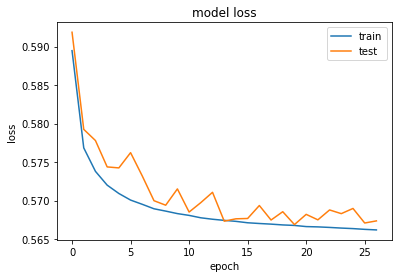

In [7]:
# Evaluation

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
plot_train_history_loss(autoencoder_history)

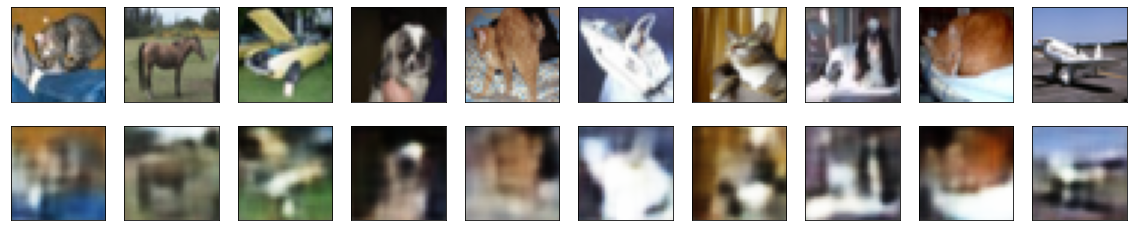

In [8]:
# Visualize examples before and after autoencoder

decoded_imgs = autoencoder.predict(x_test)

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(32, 32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(32, 32,3))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructed(x_test, decoded_imgs, 10)

##  2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the architectural choices you've made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model's performance on training set and test set.



*   Filter is the dimensionality of the output space. For this model, the filters we used are 32, 64 and 128. Higher filter number means the model could learn different parts of a graph.
*  Kernal size specifies the hight and width pf the 2D convolution window, and here we use 2*2.
*   Stride shows the way our kernel move across the image. Stride of 1 is like a sliding window, and stride of 2 or more will skip some pixels. Here we use the default value.
*   Padding is the way we handle the border of the image where the kernel has no pixels to overlap.Between "valid" and "same", we chose "same".





In [9]:
# CNN Model 
model = tfk.Sequential()

model.add(tfkl.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.Conv2D(32, (3, 3), padding ='same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid', data_format = None))
model.add(tfkl.Dropout(0.25))
model.add(tfkl.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(tfkl.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'same', data_format = None))
model.add(tfkl.Dropout(0.25))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(256, input_shape = (256, )))
model.add(tfkl.Dense(10))
model.add(tfkl.LeakyReLU(0.1))
model.add(tfkl.Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0

In [10]:
# Train the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

deep_cnn_history = model.fit(x_train,
                             y_train,
                             batch_size=64,
                             epochs=100,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)

Epoch 1/100
782/782 [==============================] - 5s 6ms/step - loss: 1.5052 - accuracy: 0.4553 - val_loss: 1.1412 - val_accuracy: 0.5935
Epoch 2/100
782/782 [==============================] - 5s 6ms/step - loss: 1.0733 - accuracy: 0.6216 - val_loss: 0.9489 - val_accuracy: 0.6611
Epoch 3/100
782/782 [==============================] - 4s 6ms/step - loss: 0.9312 - accuracy: 0.6738 - val_loss: 0.8914 - val_accuracy: 0.6885
Epoch 4/100
782/782 [==============================] - 4s 6ms/step - loss: 0.8499 - accuracy: 0.7024 - val_loss: 0.8364 - val_accuracy: 0.7134
Epoch 5/100
782/782 [==============================] - 4s 6ms/step - loss: 0.7926 - accuracy: 0.7240 - val_loss: 0.8357 - val_accuracy: 0.7066
Epoch 6/100
782/782 [==============================] - 4s 6ms/step - loss: 0.7510 - accuracy: 0.7387 - val_loss: 0.7827 - val_accuracy: 0.7289
Epoch 7/100
782/782 [==============================] - 4s 6ms/step - loss: 0.7240 - accuracy: 0.7469 - val_loss: 0.7865 - val_accuracy: 0.7267

313/313 [==============================] - 1s 3ms/step - loss: 0.7208 - accuracy: 0.7610
The test score: [0.7207937836647034, 0.7609999775886536]


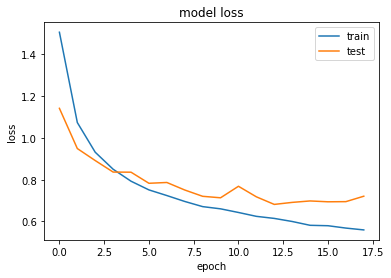

In [11]:
# Evaluation

score = model.evaluate(x_test, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))


def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(deep_cnn_history)

## 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-ity of your model. You should only train the final Dense layer, all other weightsshould be fixed. You can use whichever pre-trained backbone you like (ResNet,VGG, etc). Report on your model’s performance on the training set and testset.

In [12]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [13]:
# Load Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [14]:
# One hot Encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
# Resize
# Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48

x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

In [16]:
base_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

# Add classification layers on top of it
x = tfkl.GlobalAveragePooling2D()(last)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dense(256, activation='relu')(x)
x = tfkl.Dense(256, activation='relu')(x)
x = tfkl.Dropout(0.6)(x)
pred = tfkl.Dense(10, activation='softmax')(x)
model = Model(base_model.input, pred)

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
for layer in base_model.layers:
     layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

In [18]:
# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

In [19]:
# Model training
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

vgg_history = model.fit(x_train,
                             y_train,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)

# Batch Size Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.
# Here is 1563*32

Epoch 1/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2401 - accuracy: 0.4468 - val_loss: 0.1793 - val_accuracy: 0.6106
Epoch 2/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1878 - accuracy: 0.5880 - val_loss: 0.1564 - val_accuracy: 0.6613
Epoch 3/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1696 - accuracy: 0.6312 - val_loss: 0.1450 - val_accuracy: 0.6896
Epoch 4/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1588 - accuracy: 0.6589 - val_loss: 0.1375 - val_accuracy: 0.7074
Epoch 5/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1516 - accuracy: 0.6760 - val_loss: 0.1326 - val_accuracy: 0.7193
Epoch 6/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1460 - accuracy: 0.6876 - val_loss: 0.1287 - val_accuracy: 0.7269
Epoch 7/40
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1416 - accuracy: 0.6997 - val_loss: 0.1259 - val_ac

313/313 [==============================] - 2s 6ms/step - loss: 0.1079 - accuracy: 0.7755
The test score: [0.10789481550455093, 0.7754999995231628]


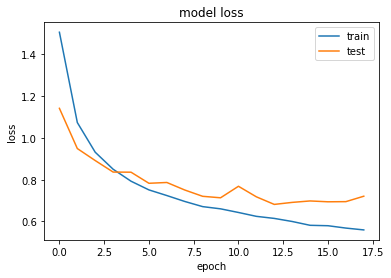

In [20]:
# Evaluation
score = model.evaluate(x_test, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(deep_cnn_history)

## 3.1 RNN for Text Classification

In [21]:
# Import data
data = pd.read_csv("SPAM_detection.csv")
data.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [22]:
# Seperate target and text
x = data['Message']
y = data['category_val']

# Train Test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(4179,), y=(4179,)
Test: X=(1393,), y=(1393,)


In [23]:
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
word_dict = tokenizer.index_word  # word_dict is ordered by the frequency of words.

print(len(word_dict))

9004


In [24]:
# Sequences from Sentences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Create pad of fixed length
x_train_pad = pad_sequences(x_train_seq, maxlen=50, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=50, padding='post')

In [25]:
# LSTM model
laenge_pads = 50
anz_woerter = 9004

lstm_model = tfk.Sequential()
lstm_model.add(tfkl.Embedding(input_dim=anz_woerter+1,  # size of the vocabulary in the text data. Eg. If your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
                              output_dim=50, # This is the size of the vector space in which words will be embedded
                              input_length=laenge_pads))   # length of input sequences
lstm_model.add(tfkl.LSTM(400))
lstm_model.add(tfkl.Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', 
                   optimizer = optimizers.Adam(lr=1e-4), 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            450250    
_________________________________________________________________
lstm (LSTM)                  (None, 400)               721600    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 401       
Total params: 1,172,251
Trainable params: 1,172,251
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Model Training
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

lstm_history = lstm_model.fit(x_train_pad,
                        y_train,
                        batch_size=32,
                        epochs=20,
                        validation_data=(x_test_pad, y_test),
                        callbacks=callbacks)

Epoch 1/20
131/131 [==============================] - 2s 16ms/step - loss: 0.3420 - accuracy: 0.8799 - val_loss: 0.1284 - val_accuracy: 0.9648
Epoch 2/20
131/131 [==============================] - 2s 12ms/step - loss: 0.1102 - accuracy: 0.9675 - val_loss: 0.0724 - val_accuracy: 0.9806
Epoch 3/20
131/131 [==============================] - 2s 12ms/step - loss: 0.0512 - accuracy: 0.9878 - val_loss: 0.0606 - val_accuracy: 0.9828
Epoch 4/20
131/131 [==============================] - 2s 12ms/step - loss: 0.0352 - accuracy: 0.9933 - val_loss: 0.0591 - val_accuracy: 0.9828
Epoch 5/20
131/131 [==============================] - 2s 12ms/step - loss: 0.0271 - accuracy: 0.9952 - val_loss: 0.0635 - val_accuracy: 0.9835
Epoch 6/20
131/131 [==============================] - 1s 11ms/step - loss: 0.0209 - accuracy: 0.9962 - val_loss: 0.0864 - val_accuracy: 0.9813
Epoch 7/20
131/131 [==============================] - 2s 12ms/step - loss: 0.0216 - accuracy: 0.9955 - val_loss: 0.0645 - val_accuracy: 0.9828

44/44 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.9828
The test score: [0.0644654706120491, 0.9827709794044495]


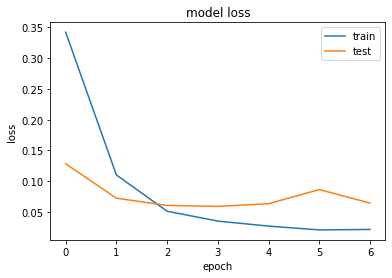

In [27]:
# Evaluation
score = lstm_model.evaluate(x_test_pad, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(lstm_history)

## 3.2 CNN

Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). You might gain some insight and inspiration from these text classification approaches:1.http://www.aclweb.org/anthology/D14-11812. 2. https://arxiv.org/abs/1702.08568    Tips: after splitting every character in each training sample, the maximum length of training samples can be really big.  If you choose to only do the padding trick to all the samples, it might raise OOM issues. So instead of padding only, you can also cut each sample at a certain point, which can maketraining more efficient and feasible while using CNN.

In [28]:
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(x_train)

# Convert string to index
train_sequences = tk.texts_to_sequences(x_train)
test_texts = tk.texts_to_sequences(x_test)


In [29]:
# Padding
train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

In [30]:
# Number of vocabulary
print(tk.word_index)
print(len(tk.word_index))
vocab_size = len(tk.word_index)

{'UNK': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'i': 7, 'n': 8, 's': 9, 'r': 10, 'l': 11, 'h': 12, 'u': 13, 'd': 14, '.': 15, 'm': 16, 'y': 17, 'c': 18, 'w': 19, 'g': 20, 'p': 21, 'f': 22, 'b': 23, 'k': 24, 'v': 25, '0': 26, ',': 27, "'": 28, '1': 29, '2': 30, 'x': 31, '?': 32, '!': 33, '8': 34, '5': 35, '4': 36, '&': 37, 'j': 38, '7': 39, '3': 40, ';': 41, '6': 42, ':': 43, '9': 44, '-': 45, 'z': 46, ')': 47, '/': 48, '£': 49, '#': 50, '*': 51, 'q': 52, '"': 53, 'ü': 54, '+': 55, '(': 56, '=': 57, '|': 58, '\x92': 59, '@': 60, '>': 61, '‘': 62, '$': 63, '_': 64, '…': 65, '–': 66, '%': 67, '<': 68, '\x94': 69, 'é': 70, '~': 71, '\\': 72, '\n': 73, '\t': 74, '“': 75, '¡': 76, '[': 77, ']': 78, '\x93': 79, '\x96': 80, '\x91': 81, '^': 82, 'ú': 83, '鈥': 84, '┾': 85, '〨': 86, '»': 87, 'ì': 88}
88


In [31]:
# Use one-hot encoder to present vocab
embedding_weights = []
embedding_weights.append(np.zeros(vocab_size)) #zero vector to represent PAD

for char,i in tk.word_index.items():   # from index 1 to 82
  onehot = np.zeros(vocab_size)
  onehot[i-1] = 1
  embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)

print(embedding_weights.shape)
embedding_weights

(89, 88)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [34]:
# parameter setup
input_size = 1014
vocab_size = len(tk.word_index)
embedding_size = 88
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]

fully_connected_layers = [1024, 1024]
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'    

# Embedding layer Initialization
embedding_layer = tfkl.Embedding(vocab_size+1,
                            embedding_size,
                            input_length = input_size,
                            weights = [embedding_weights])

In [38]:
# Model Construction

# Input
inputs = tfkl.Input(shape=(input_size,), name='input', dtype='int64') 

# Embedding
x = embedding_layer(inputs)

# Conv
for filter_num, filter_size, pooling_size in conv_layers:
    x = tfkl.Conv1D(filter_num, filter_size)(x)
    x = tfkl.Activation('relu')(x)
    if pooling_size != -1:
        x = tfkl.MaxPooling1D(pool_size=pooling_size)(x)  # Final shape=(None, 34, 256)
x = tfkl.Flatten()(x)  # (None, 8704)

# Fully connected layers
for dense_size in fully_connected_layers:
    x = tfkl.Dense(dense_size, activation='relu')(x)  # dense_size == 1024
    x = tfkl.Dropout(dropout_p)(x)

# Output Layer
predictions = tfkl.Dense(1, activation='sigmoid')(x)

# Build model
cnn_model = Model(inputs=inputs, outputs=predictions)
cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
cnn_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1014)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1014, 88)          7832      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1008, 256)         157952    
_________________________________________________________________
activation_7 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_8 (Activation)    (None, 330, 256)         

In [39]:
# Model Training
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

CNN_history = cnn_model.fit(train_data,
                        y_train,
                        batch_size=32,
                        epochs=20,
                        validation_data=(test_data, y_test),
                        callbacks=callbacks)

Epoch 1/20
131/131 [==============================] - 5s 36ms/step - loss: 0.1849 - accuracy: 0.9435 - val_loss: 0.0898 - val_accuracy: 0.9821
Epoch 2/20
131/131 [==============================] - 4s 34ms/step - loss: 0.0816 - accuracy: 0.9806 - val_loss: 0.0963 - val_accuracy: 0.9806
Epoch 3/20
131/131 [==============================] - 4s 34ms/step - loss: 0.0570 - accuracy: 0.9861 - val_loss: 0.0950 - val_accuracy: 0.9734
Epoch 4/20
131/131 [==============================] - 4s 34ms/step - loss: 0.0486 - accuracy: 0.9899 - val_loss: 0.0822 - val_accuracy: 0.9799
Epoch 5/20
131/131 [==============================] - 5s 35ms/step - loss: 0.0404 - accuracy: 0.9904 - val_loss: 0.0889 - val_accuracy: 0.9842
Epoch 6/20
131/131 [==============================] - 5s 35ms/step - loss: 0.0247 - accuracy: 0.9945 - val_loss: 0.1129 - val_accuracy: 0.9835
Epoch 7/20
131/131 [==============================] - 4s 34ms/step - loss: 0.0196 - accuracy: 0.9962 - val_loss: 0.0903 - val_accuracy: 0.9856

44/44 [==============================] - 1s 13ms/step - loss: 0.0903 - accuracy: 0.9856
The test score: [0.09026864916086197, 0.9856424927711487]


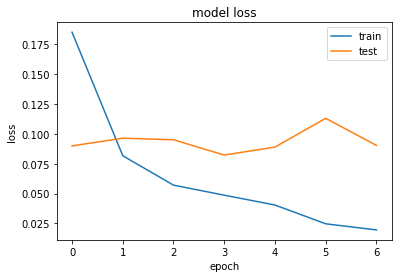

In [40]:
# Evaluation
score = cnn_model.evaluate(test_data, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(CNN_history)

## 3.3 Model Comparison

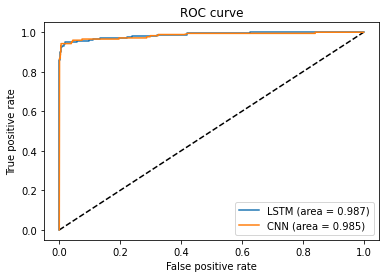

In [41]:
# LSTM and CNN ROC Curve
y_pred_keras = lstm_model.predict(x_test_pad).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

cnn_y_pred_keras = cnn_model.predict(test_data).ravel()
cnn_fpr_keras, cnn_tpr_keras, cnn_thresholds_keras = roc_curve(y_test, cnn_y_pred_keras)
cnn_auc_keras = auc(cnn_fpr_keras, cnn_tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.plot(cnn_fpr_keras, cnn_tpr_keras, label='CNN (area = {:.3f})'.format(cnn_auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

We could see the output of CNN and LSTM are pretty similar.